<a href="https://colab.research.google.com/github/Sonlowami/HAI-DEF-Learn/blob/main/train_elixr_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Authentication

In [1]:
from huggingface_hub import notebook_login, snapshot_download, hf_hub_download, HfFolder
import tensorflow as tf
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, Image
print(tf.test.is_built_with_cuda())

True


In [7]:
if HfFolder.get_token() is None:
  notebook_login()
else:
  print('Token already set')

Token already set


# **Load the models from HuggingFace**

In [8]:
REPO_ID = 'google/cxr-foundation'
LOCAL_DIR = '/content/cxr-foundation/models'
repository_path = snapshot_download(repo_id=REPO_ID,
                                    allow_patterns=['elixr-c-v2-pooled/*', 'pax-elixr-b-text/*'],
                                    local_dir=LOCAL_DIR)
repository_path

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

'/content/cxr-foundation/models'

In [9]:
path = Path(repository_path)
[p for p in path.iterdir()]

[PosixPath('/content/cxr-foundation/models/.cache'),
 PosixPath('/content/cxr-foundation/models/pax-elixr-b-text'),
 PosixPath('/content/cxr-foundation/models/elixr-c-v2-pooled')]

# Download the dataset

In [10]:
!pip install datasets
from datasets import load_dataset, concatenate_datasets
pneumo_ds = load_dataset("hf-vision/chest-xray-pneumonia")

In [13]:
train = pneumo_ds['train']
validation = pneumo_ds['validation']
test = pneumo_ds['test']

print(f'Training shape: {train.shape}')
print(f'Validation shape: {validation.shape}')
print(f'Test shape: {test.shape}')

Training shape: (5216, 2)
Validation shape: (16, 2)
Test shape: (624, 2)


[Text(0, 0, 'Pneumonia'), Text(1, 0, 'Normal')]

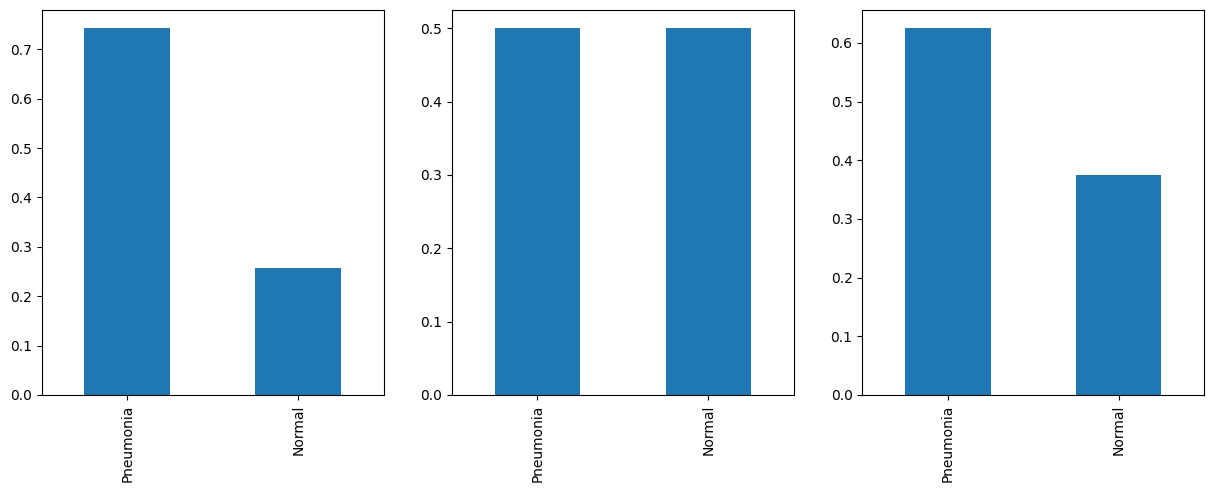

In [14]:
train_labels = pd.Series(train['label'])
validation_labels = pd.Series(validation['label'])
test_labels = pd.Series(test['label'])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
train_labels.value_counts(normalize=True).plot(kind='bar', ax=ax[0]).xaxis.set_ticklabels(['Pneumonia', 'Normal'])
validation_labels.value_counts(normalize=True).plot(kind='bar', ax=ax[1]).xaxis.set_ticklabels(['Pneumonia', 'Normal'])
test_labels.value_counts(normalize=True).plot(kind='bar', ax=ax[2]).xaxis.set_ticklabels(['Pneumonia', 'Normal'])


**Balancing the Dataset**

There are two issues here:

1. The normal cases are 1/4 of the data. This means the model will be more likely to choose a normal over an abnormal image
2. The validation dataset is only 16 images long. This is a problem because normally, we would need the validation dataset to be a 10th of the training data available

**Solution:**
We are going to do the following:

- Recombine training and validation dataset into a single dataset
- Augment images to generate more data
- Random oversample the minority class
- Do the splitting again into train and validation dataset

In [15]:
train_val = concatenate_datasets([train, validation])
train_val.shape[0] == train.shape[0]+ validation.shape[0]

True

In [16]:
positive_class = train_val.filter(lambda example: example['label'] == 1)
negative_class = train_val.filter(lambda example: example['label'] == 0)
print(f'Positive class shape: {positive_class.shape}')
print(f'Negative class shape: {negative_class.shape}')

Positive class shape: (3883, 2)
Negative class shape: (1349, 2)


Positive Class


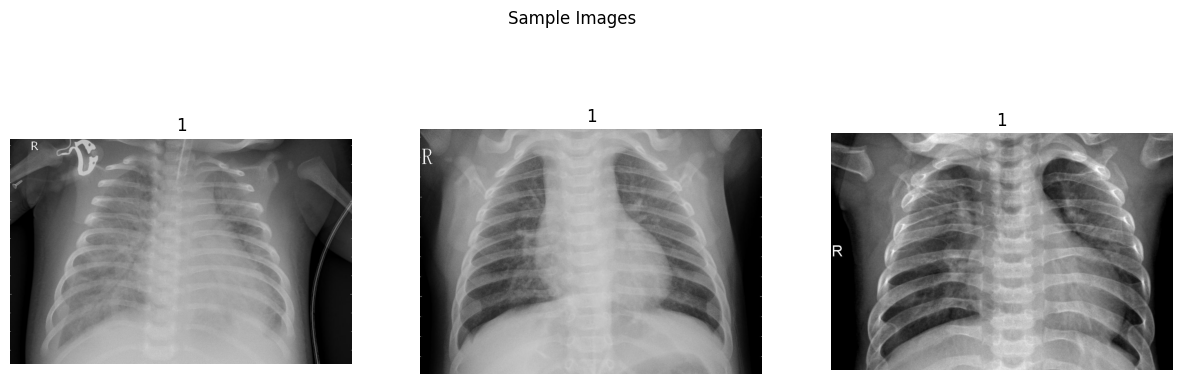

In [17]:
import datasets
def display_sample_images(dataset, num_samples=3):
  fig, ax = plt.subplots(1, num_samples, figsize=(15, 5))
  fig.suptitle('Sample Images')
  match (type(dataset)):
    case datasets.Dataset:
      for i in range(num_samples):
        sample = dataset[i]
        pil_image = sample['image'].convert("RGB")
        image_array = np.array(pil_image)
        ax[i].imshow(image_array)
        ax[i].axis('off')
        ax[i].set_title(sample['label'])
    #case tf.data.Dataset:
    #  for i, sample in enumerate(dataset.take(num_samples)):
    #    pil_image = tf.keras.preprocessing.image.array_to_img(sample['image'])
    #    image_array = np.array(pil_image.convert("RGB"))
    #    fig.add_trace(go.Image(z=image_array), row=1, col=i+1)
    # fig.update_layout(height=800, width=1200, title_text='Sample Images')
  fig.show()

print('Positive Class')
display_sample_images(positive_class)

Negative Class


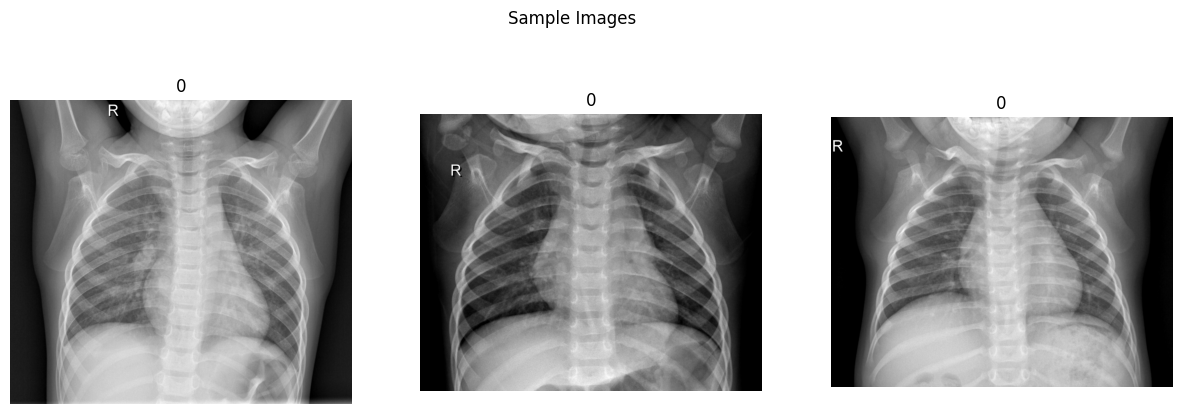

In [18]:
print('Negative Class')
display_sample_images(negative_class)

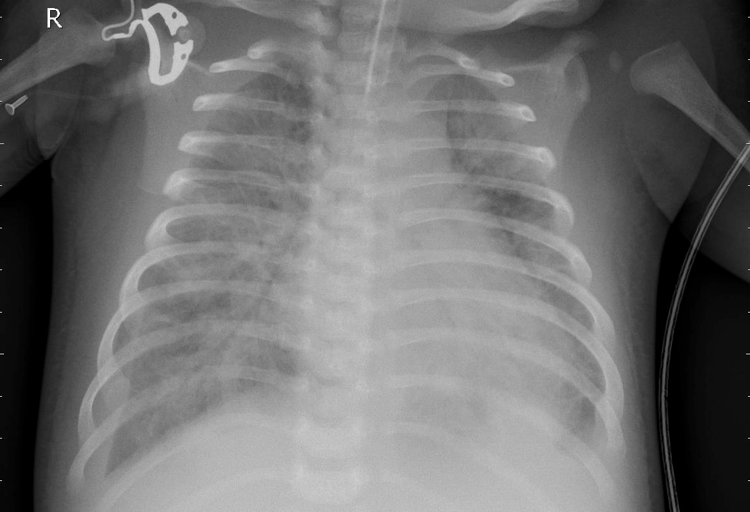

In [19]:
def augment_image(image: tf.Tensor) -> tf.Tensor:
  image = tf.image.random_brightness(image, max_delta=0.3)
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
  image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
  return image

np_image = np.array(positive_class[0]['image'].convert('RGB'))
aug_image_tensor = augment_image(tf.convert_to_tensor(np_image))
aug_image = tf.keras.preprocessing.image.array_to_img(aug_image_tensor)
display(aug_image.resize((750, 512)))



In [20]:
def augment_class(dataset, p, batch_size=32):
    '''
    Efficiently augment a dataset by processing in batches
    with a given probability p.
    '''
    def augment_batch(batch):
        augmented_batch = []
        for i in range(len(batch['image'])):
            sample = batch['image'][i]
            if np.random.rand() < p:
                # Convert to NumPy array and augment
                np_image = np.array(sample.convert('RGB'))
                aug_image_tensor = augment_image(tf.convert_to_tensor(np_image))
                # Convert back to PIL Image
                aug_image = tf.keras.preprocessing.image.array_to_img(aug_image_tensor)
                augmented_batch.append({'image': aug_image, 'label': batch['label'][i]})
        return augmented_batch

    # Process dataset in batches
    augmented_dataset = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]
        augmented_dataset.extend(augment_batch(batch))

    return datasets.Dataset.from_list(augmented_dataset)

In [21]:
aug_dataset = augment_class(positive_class, 0.1)
print(type(aug_dataset))

<class 'datasets.arrow_dataset.Dataset'>


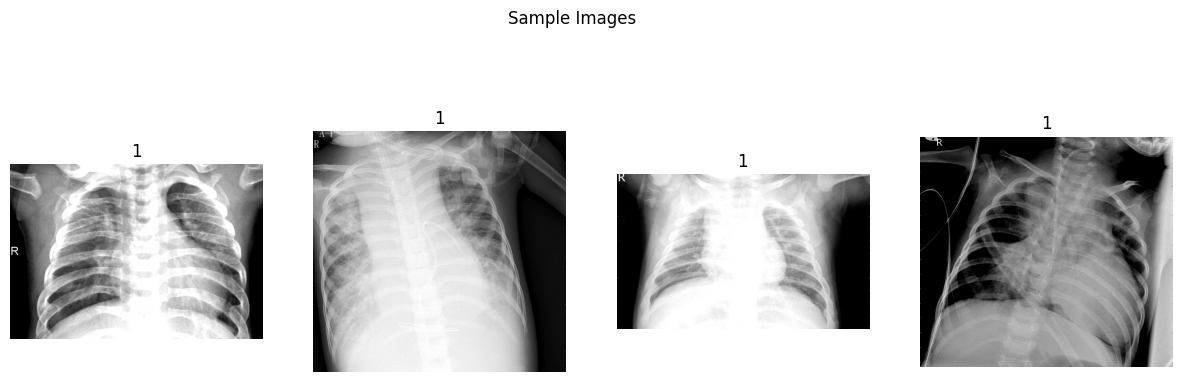

In [22]:
display_sample_images(aug_dataset, 4)

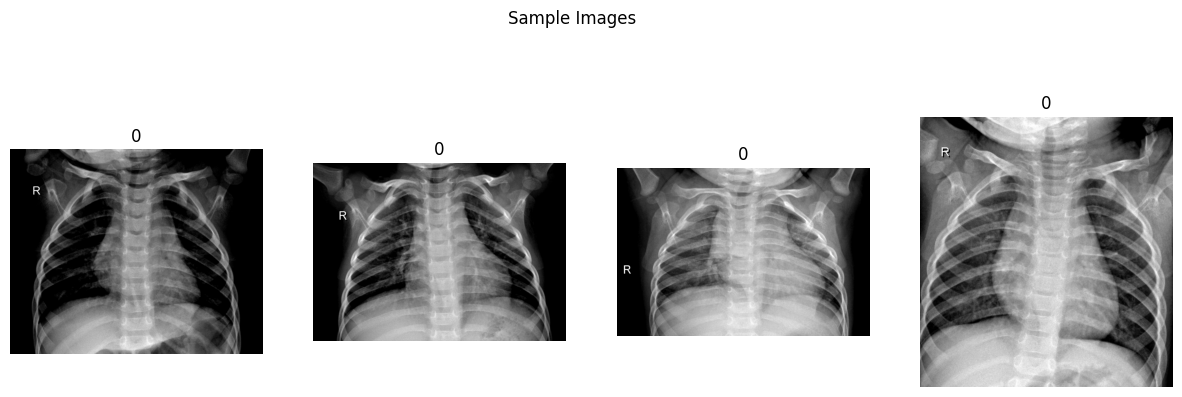

In [23]:
aug_neg_dataset = augment_class(negative_class, 0.3)
display_sample_images(aug_neg_dataset, 4)

In [24]:
features = datasets.Features({
    'image': datasets.Image(),
    'label': datasets.Value(dtype='int64')
})

aug_dataset = aug_dataset.cast(features)
aug_neg_dataset = aug_neg_dataset.cast(features)
train_val = train_val.cast(features)

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/414 [00:00<?, ? examples/s]

In [25]:
dataset = concatenate_datasets([train_val, aug_dataset, aug_neg_dataset])
dataset.shape

(6046, 2)

<Axes: >

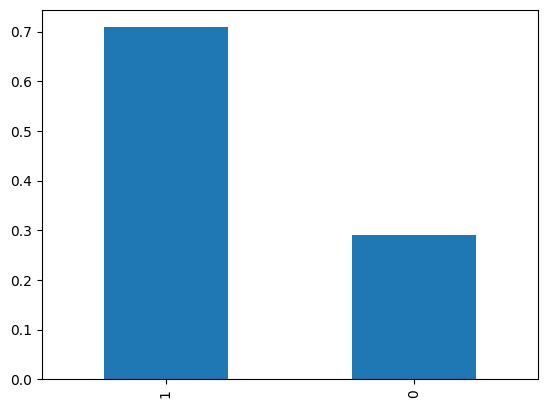

In [26]:
label_series = pd.Series(dataset['label'])
label_series.value_counts(normalize=True).plot(kind='bar')

In [27]:
!pip install pypng >> /dev/null
import png
from PIL import Image
import io
def pil_to_tfexample(pil_image: Image) -> tf.train.Example:
    """Creates a tf.train.Example from a PIL Image."""
    # Convert the PIL Image to grayscale and ensure it's in the correct mode
    if pil_image.mode != 'L':  # 'L' mode is grayscale
        pil_image = pil_image.convert('L')

    # Convert the PIL Image directly to a NumPy array
    image_array = np.array(pil_image, dtype=np.uint16)

    # Determine the bit depth and scale the array accordingly
    bitdepth = 8 if image_array.max() <= 255 else 16
    if bitdepth == 16:
        image_array = (image_array / image_array.max() * 65535).astype(np.uint16)

    # Encode the NumPy array as PNG
    output = io.BytesIO()
    png.Writer(
        width=image_array.shape[1],
        height=image_array.shape[0],
        greyscale=True,
        bitdepth=bitdepth
    ).write(output, image_array.tolist())
    png_bytes = output.getvalue()

    # Create a tf.train.Example and assign the features
    example = tf.train.Example()
    features = example.features.feature
    features['image/encoded'].bytes_list.value.append(png_bytes)
    features['image/format'].bytes_list.value.append(b'png')

    return example


In [ ]:
def generate_embeddings(img: Image):
  serialized_img = pil_to_tfexample(img).SerializeToString()

  if 'elixrc_model' not in locals():
    elixrc_model = tf.saved_model.load('/content/cxr-foundation/models/elixr-c-v2-pooled')
    elixrc_infer = elixrc_model.signatures['serving_default']

  output = elixrc_infer(input_example=tf.constant([serialized_img]))
  elixrc_embedding = output['feature_maps_0'].numpy()
  print("ELIXR-C - interim embedding shape: ", elixrc_embedding.shape)

  if 'qformer_model' not in locals():
    qformer_model = tf.saved_model.load('/content/cxr-foundation/models/pax-elixr-b-text')
    qformer_infer = qformer_model.signatures['serving_default']

  qformer_input = {
      'image_feature': elixrc_embedding.tolist(),
      'ids': np.zeros((1, 1, 128), dtype=np.int32).tolist(),
      'paddings': np.zeros((1, 1, 128), dtype=np.float64).tolist()
  }
  q_former_output = qformer_infer(**qformer_input)
  elixrb_embeddings = q_former_output['all-contrastive-img-emb']

  return elixrb_embeddings


# References:

1. Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2